#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Interpolation

Interpolation and regression address the problem of approximating functions using their (possibly noisy) values at a finite set of points.  There is usually an underlying process from which the observed data are obtained, but this process is impractical to evaluate every time a function value is needed.  Examples of underlying processes include:

* direct field observations/measurement of a physical or social system
* numerically processed observations, perhaps by applying physical principles
* output from an expensive "exact" numerical computation
* output from an approximate numerical computation

We would like an inexpensive deterministic surrogate that we can use instead.  The most common surrogate functions are polynomials and rational functions (ratios of polynomials) because they are convenient to compute with.  Other choices are often made when there is prior knowledge about the behavior of the system, such as using

* $\sin kx$ and $\cos kx$ to represent periodic functions
* powers/exponentials ($a^x$ or $a^{1/x}$) for material properties or reaction rates (e.g., [Arhennius relations](https://en.wikipedia.org/wiki/Arrhenius_equation)).

We start our discussion by building surrogate functions that exactly match the observations at a number of points, either given or specially chosen, using polynomials.

## Polynomial Interpolation

In the Linear Algebra notebook, we discussed Vandermonde matrices which we could use to solve for polynomial coefficients.  It is also possible to compute the coefficients explicitly (rather than by solving a linear system).

### Lagrange Interpolating Polynomials

Suppose we are given function values $y_0, \dotsc, y_m$ at the distinct points $x_0, \dotsc, x_m$ and we would like to build a polynomial of degree $m$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(x) = \sum_{i=0}^m y_i \prod_{j \ne i} \frac{x - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = y_i$?
* How expensive (in terms of $m$) is it to evaluate $p(x)$?
* How expensive (in terms of $m$) is it to convert to standard form $p(x) = \sum_{i=0}^m a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

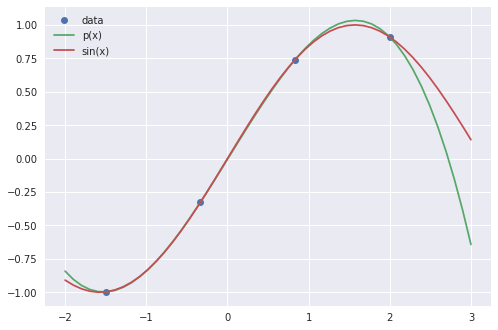

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.max_open_warning'] = False

def lagrange(x, y):
    @np.vectorize
    def p(t):
        from numpy import prod
        m = len(x) - 1
        w = 0
        for i in range(m):
            w += y[i] * (prod(t - x[:i]) * prod(t - x[i+1:])
                / (prod(x[i] - x[:i]) * prod(x[i] - x[i+1:])))
        w += y[m] * prod(t - x[:m]) / prod(x[m] - x[:m])
        return w
    return p

x = np.linspace(-1.5,2,4)
y = np.sin(x)
p = lagrange(x, y)
xx = np.linspace(-2,3)

plt.plot(x, y, 'o', label='data')
plt.plot(xx, p(xx), label='p(x)')
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.legend(loc='upper left');

#### Uniqueness

Is the polynomial $p(x)$ of degree $m$ that interpolates $m+1$ points unique?  Why?

### Vandermonde matrices

We have used the Vandermonde matrix with a monomial basis for polynomial interpolation.

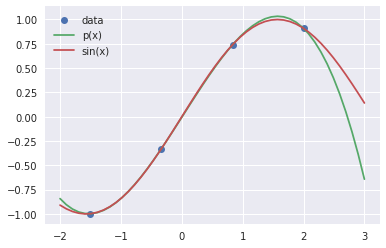

In [2]:
p = np.linalg.solve(np.vander(x), y)
plt.plot(x, y, 'o', label='data')
plt.plot(xx, np.vander(xx, 4) @ p, label='p(x)')
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.legend(loc='upper left');

Vandermonde matrices are often ill-conditioned and this requires solving an $m\times m$ linear system, at a cost of $m^3$.

### Newton polynomials

Newton polynomials are polynomials

$$ n_k(x) = \prod_{i=0}^{k-1} (x - x_i) $$

How does the Vandermonde procedure change if we replace $x^k$ with $n_k(x)$?

In [3]:
def vander_newton(x, abscissa=None):
    if abscissa is None:
        abscissa = x
    n = len(abscissa)
    A = np.zeros((len(x), n))
    A[:,0] = 1
    for i in range(1,n):
        A[:,i] = A[:,i-1] * (x - abscissa[i-1])
    return A

A = vander_newton(np.linspace(-1,1,5))
print(A)

[[ 1.    0.   -0.    0.   -0.  ]
 [ 1.    0.5   0.   -0.    0.  ]
 [ 1.    1.    0.5   0.   -0.  ]
 [ 1.    1.5   1.5   0.75  0.  ]
 [ 1.    2.    3.    3.    1.5 ]]


* Does this affect the cost of solving for the coefficients?
* How does the condition number depend on the number and position of the points?

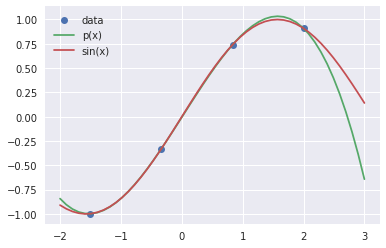

In [4]:
# First, let's check that it works.
p = np.linalg.solve(vander_newton(x), y)

plt.plot(x, y, 'o', label='data')
plt.plot(xx, vander_newton(xx, x) @ p, label='p(x)')
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.legend(loc='upper left');

## Conditioning of the Vandermonde matrix

Recall that the condition number of a matrix, the ratio of its largest and smallest singular values
$$\kappa = \frac{\sigma_\max}{\sigma_\min} ,$$
controls the accuracy achievable using an ideal (backward stable) algorithm to
$$ (\text{error}) \approx \kappa \epsilon_{\text{machine}} . $$

If we will use a Vandermonde matrix to solve interpolation problems, we should check that its condition number is not too big (sometimes we'll say "bounded").

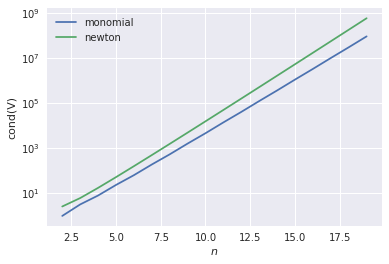

In [5]:
def cond(mat, points, interval=(-1,1), nmax=20):
    degree = np.arange(2, nmax)
    return degree, np.array(
        [np.linalg.cond(mat(points(*interval,n))) 
         for n in degree])

plt.semilogy(*cond(np.vander, np.linspace, (-1,1)), label='monomial')
plt.semilogy(*cond(vander_newton, np.linspace, (-1,1)), label='newton')
plt.legend(loc='upper left')
plt.ylabel('cond(V)')
plt.xlabel('$n$');

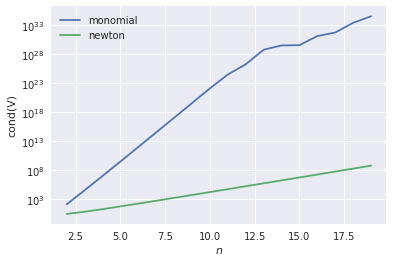

In [6]:
# What if the interval is not centered on the origin?
plt.semilogy(*cond(np.vander, np.linspace, (10,12)), label='monomial')
plt.semilogy(*cond(vander_newton, np.linspace, (10,12)), label='newton')
plt.legend(loc='upper left')
plt.ylabel('cond(V)')
plt.xlabel('$n$');

### Conclusions

* Vandermonde matrices are typically ill-conditioned. Even with many points, columns typically become nearly linearly dependent.
* Interpolation using an arbitrary basis requires $O(n^3)$ operations for $n$ data points because we must solve with a full Vandermonde matrix.
* Newton polynomials cause the Vandermonde matrix to be triangular, thus $O(n^2)$ for interpolation.
* Newton polynomials can incrementally assimilate new observations: just add extra rows.

### Polynomial bases

We have seen that monomials and Newton bases are ill-conditioned, but we have a procedure for constructing well-conditioned (orthonormal) bases that span the same space.

R [[-1.87082869 -0.46770717 -2.0265401  -1.46144168]
 [ 0.          1.89012152  0.94506076  3.8266857 ]
 [ 0.          0.         -1.70775382 -1.28081537]
 [ 0.          0.          0.          1.51479906]]


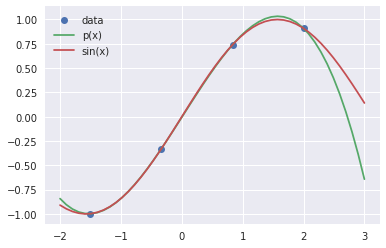

In [7]:
def vander_q(x, n=None, interval=None, print_basis=False):
    if n is None:
        n = len(x)
    if interval is None:
        a, b = min(x), max(x)
    else:
        a, b = interval
    # Set up integration on the interval [a,b] using the midpoint rule
    w = b - a
    V = np.vander(np.linspace(a + 0.5*w/100, b - 0.5*w/100, 100),
                     n, increasing=True)
    V *= np.sqrt(w/100)
    Q, R = np.linalg.qr(V)
    if print_basis:
        print('R', R)
    A = np.vander(x, n, increasing=True)
    return np.linalg.solve(R.T, A.T).T

p = np.linalg.solve(vander_q(x, print_basis=True), y)

plt.plot(x, y, 'o', label='data')
plt.plot(xx, vander_q(xx, 4, interval=(min(x), max(x))) @ p, label='p(x)')
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.legend(loc='upper left');

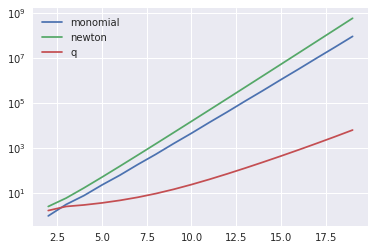

In [8]:
plt.semilogy(*cond(np.vander, np.linspace, (-1,1)), label='monomial')
plt.semilogy(*cond(vander_newton, np.linspace, (-1,1)), label='newton')
plt.semilogy(*cond(vander_q, np.linspace, (-1,1)), label='q')
plt.legend(loc='upper left');

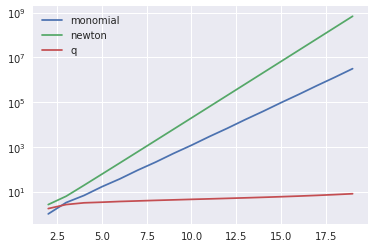

In [9]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (
        np.cos(np.linspace(-np.pi, 0, n)))

plt.semilogy(*cond(np.vander, cosspace, (-1,1)), label='monomial')
plt.semilogy(*cond(vander_newton, cosspace, (-1,1)), label='newton')
plt.semilogy(*cond(vander_q, cosspace, (-1,1)), label='q')
plt.legend(loc='upper left');

### Observations

* Orthogonalizing the monomials makes for a much better conditioned basis.
* That basis has much smaller condition number for interpolation on equally spaced points.
* The condition number still grows exponentially.
* Using `cosspace` for interpolation with monomials or Newton basis does not qualitatively change their ill-conditioning.
* Using `cosspace` with orthogonal polynomials gives a small condition number.
* The orthogonal polynomials can be written as a linear combination of monomials.
* That is, a different sequence of constant, linear, quadratic, etc., polynomials.

### Another look at these polynomials

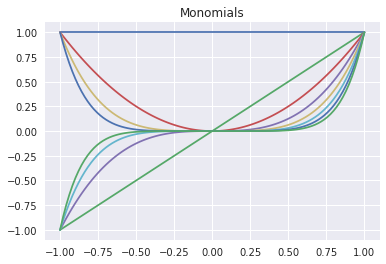

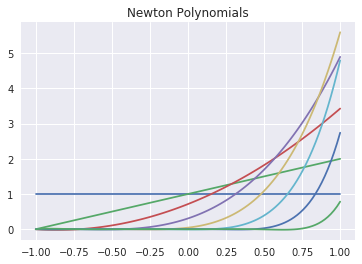

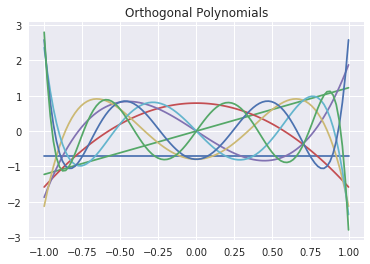

In [10]:
x = np.linspace(-1, 1, 100)
M = np.vander(x, 8, increasing=True)
N = vander_newton(x, abscissa=np.linspace(-1,1,8))
Q = vander_q(x, 8)

plt.plot(x, M)
plt.title('Monomials')

plt.figure()
plt.plot(x, N)
plt.title('Newton Polynomials')

plt.figure()
plt.plot(x, Q)
plt.title('Orthogonal Polynomials');

Constructing these "good" (orthogonal) polynomials using QR factorization is a bit cumbersome and depends on a finite accuracy parameter.

* Which parameter controls accuracy?

### Legendre Polynomials

Classical (19th century) mathematics discovered the polynomials we are approximating because they are eigenfunctions (resonant modes) of a differential operator,
$$ \frac{d}{d x} (1 - x^2) \frac{d P_n(x)}{dx} . $$
They can also be derived by exact Gram-Schmidt orthogonalization in the $L^2$ inner product (you did this in Homework 2).
Anyway, the classical theory led to a recursive definition
$$\begin{split}
P_0(x) &= 1 \\
P_1(x) &= x \\
(n+1) P_{n+1}(x) &= (2n+1) x P_n(x) - n P_{n-1}(x)
\end{split}$$

We can implement this recurrence in code to efficiently evaluate Legendre polynomials.

In [ ]:
def vander_legendre(x, n=None):
    if n is None:
        n = len(x)
    P = np.ones((len(x), n))
    if n > 1:
        P[:,1] = x
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
    return P

P = vander_legendre(x, 8)
plt.plot(x, P)
plt.title('Legendre Polynomials');

In [ ]:
# Legendre polynomials are well-conditioned

plt.semilogy(*cond(vander_q, cosspace, (-1,1)), label='q')
plt.semilogy(*cond(vander_legendre, cosspace, (-1,1)), label='legendre')
plt.legend(loc='upper left');

### Chebyshev polynomials

There is a related family of polynomials that are even more attractive for interpolation.

Define $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, but it's not obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos \big( (n+1) y \big) = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos \big( (n-1) y \big) = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces
$$ T_{n+1}(x) + T_{n-1}(x) = 2\cos ny \cos y = $$
which yields a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$
which we can also implement in code

In [ ]:
def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(1,n-1):
        T[:,k+1] = 2 * x * T[:,k] - T[:,k-1]
    return T

T = vander_chebyshev(x, 8)
plt.plot(x, T)
plt.title('Chebyshev Polynomials');

In [ ]:
# Chebyshev polynomials are also well-conditioned

plt.semilogy(*cond(vander_q, cosspace, (-1,1)), label='q')
plt.semilogy(*cond(vander_legendre, cosspace, (-1,1)), label='legendre')
plt.semilogy(*cond(vander_chebyshev, cosspace, (-1,1)), label='chebyshev')
plt.legend(loc='upper left');

In [ ]:
print(cond(vander_chebyshev, cosspace, (-1,1))[1])

This is actually amazing: converting from the values at some special points to the coefficients of some specially crafted polynomials has a constant condition number of about 1.6.  As we will find later, Chebyshev interpolation has a number of other remarkable properties.

## Runge Effect

We've seen before that the accuracy of an interpolating polynomial is often poor near (and beyond) the ends of the interval.  We've also found "good" bases for representing the polynomials and found that when "good" points are used, the condition number can be small independent of polynomial order/number of points.  When points are poorly spaced, however, the condition number grows rapidly.

In [ ]:
print(cond(vander_chebyshev, np.linspace, (-1,1))[1])

In [ ]:
def chebyshev_interp_and_eval(x, xx):
    """Matrix mapping from values at points x to values
    of Chebyshev interpolating polynomial at points xx"""
    A = vander_chebyshev(x)
    B = vander_chebyshev(xx, len(x))
    return B @ np.linalg.inv(A)

print(np.linalg.cond(chebyshev_interp_and_eval(cosspace(-1,1,20),
                                               np.linspace(-1,1,1000))))

In [ ]:
print(np.linalg.cond(chebyshev_interp_and_eval(cosspace(-1,1,20),
                                               np.linspace(-1,1,100))))

In [ ]:
print(np.linalg.cond(chebyshev_interp_and_eval(np.linspace(-1,1,20),
                                               np.linspace(-1,1,100))))

In [ ]:
print(np.linalg.cond(chebyshev_interp_and_eval(cosspace(-1,1,20),
                                               np.linspace(-2,2,100))))

#### What are we seeing?

* Constructing the polynomials from `x=cosspace` points is good (well conditioned)
* Constructing the polynomial from `x=linspace` points is bad (ill conditioned)
* We can evaluate anywhere within the interval `(-1,1)` accurately; it doesn't matter whether we use `linspace` or `cosspace`.
* Evaluating outside the interval ("extrapolation") is terrible

### What does this ill-conditioning look like in practice?

In [ ]:
def runge1(x):
    return 1 / (1 + 10*x**2)
x = np.linspace(-1,1,20)
xx = np.linspace(-1,1,100)

plt.plot(x, runge1(x), '*')
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge1(x));

In [ ]:
x = np.linspace(-1,1,21)

plt.plot(x, runge1(x), '*')
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge1(x));

In [ ]:
def runge2(x):
    return np.exp(-(4*x)**2)

plt.plot(x, runge2(x), '*')
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge2(x));

In [ ]:
x = cosspace(-1,1,20)

plt.plot(x, runge1(x), '*')
plt.plot(x, runge2(x), '^')
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge1(x))
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge2(x));

In [ ]:
def runge3(x):
    return 1.*(x > 0)

plt.plot(x, runge3(x), '*')
plt.plot(xx, chebyshev_interp_and_eval(x, xx) @ runge3(x));

### Questions

* The condition number is the ratio of largest singular value ($\sigma_{\max} = \lVert A \rVert$) to the smallest $\sigma_{\min}$.  Is the condition number large because the norm is large or because the smallest is tiny?
* Does the condition number of the `interp_and_eval` procedure above depend on the basis used to represent polynomials?

In [ ]:
x = np.linspace(-1,1,20)
A = chebyshev_interp_and_eval(x, xx)
print(A.shape, np.linalg.cond(A))
U, S, V = np.linalg.svd(A, full_matrices=0)
print(U.shape, S.shape, V.shape)
print(S[:4])

plt.plot(xx, U[:,:2])
plt.plot(x, V.T[:,:2], 'o')
plt.title('Worst amplification');

## Lagrange interpolating polynomials revisited



In [ ]:
x = np.linspace(-1, 1, 9)
Alin = chebyshev_interp_and_eval(x, xx)
plt.plot(xx, Alin[:,0:5])
plt.plot(x[:5], 0*x[:5]+1, 'ok')
plt.plot(x, 0*x, 'sk')
plt.title('linspace');

In [ ]:
x = cosspace(-1, 1, 9)
Acos = chebyshev_interp_and_eval(x, xx)
plt.plot(xx, Acos[:,0:5])
plt.plot(x[:5], 0*x[:5]+1, 'ok')
plt.plot(x, 0*x, 'sk')
plt.title('cosspace');

## Accuracy

Up to this point, we have been primarily concerned with **stability**.  That is, we have been looking for formulations in which small changes to the input do not produce large changes to the output.  Intrinsically, this problem "should" have a norm of about 1 (with suitable scaling, or using the max ($\infty$) norm -- changing the input function should change the output function by the same amount.

Now we explore accuracy: the dependence of error on the cost of interpolation.  We'll start with piecewise constant interpolation.

In [ ]:
def find_nearest(x, xx):
    """For each target (xx), find the index of the nearest source point (x)"""
    i = x.argsort()  # Indices that sort x
    x = x[i]         # x sorted
    loc = x.searchsorted(xx)
    loc -= abs(xx - x[loc-1]) < abs(xx - x.take(loc, mode='wrap'))
    return i[loc]

find_nearest(np.array([0, -1, 1]), [-.3, -.9, .2, .7])

In [ ]:
def piecewise_constant_interp_and_eval(x, xx):
    """Construct matrix for interpolation of data at x, evaluating at xx"""
    nearest = find_nearest(x, xx)
    A = np.zeros((len(xx), len(x)))
    A[np.arange(len(xx)), nearest] = 1
    return A

x = np.linspace(-1,1,15)
xx = np.linspace(-1, 1, 100)

plt.ylim(-0.2, 1.2)
plt.plot(x, runge3(x), '*')
plt.plot(xx, piecewise_constant_interp_and_eval(x, xx) @ runge3(x), label='interp')
plt.plot(xx, runge3(xx), label='exact')
plt.legend();

In [ ]:
x = np.linspace(-1,1,20)
plt.plot(x, runge1(x), '*')
plt.plot(xx, piecewise_constant_interp_and_eval(x, xx) @ runge1(x), label='interp')
plt.plot(xx, runge1(xx), label='exact')
plt.legend();

In [ ]:
print(np.linalg.cond(piecewise_constant_interp_and_eval(
    np.linspace(-1,1,71),
    np.linspace(-1,1,100))))

In [ ]:
def maxerror(interp_and_eval, f, xspace, interval, npoints):
    error = []
    for n in npoints:
        x = xspace(*interval, n)
        xx = np.linspace(*interval, 300)
        A = interp_and_eval(x, xx)
        error.append(np.linalg.norm(A @ f(x) - f(xx), np.inf))
    return error

npoints = np.arange(2, 30)

plt.loglog(npoints, maxerror(piecewise_constant_interp_and_eval, 
                             runge1, np.linspace, (-1,1), npoints),
              label='piecewise_constant')
plt.loglog(npoints, maxerror(chebyshev_interp_and_eval, 
                             runge1, cosspace, (-1,1), npoints), 
              label='chebyshev cos')
plt.loglog(npoints, maxerror(chebyshev_interp_and_eval, 
                             runge1, np.linspace, (-1,1), npoints), 
              label='chebyshev lin')
plt.loglog(npoints, 1/npoints, label='slope=-1')
plt.loglog(npoints, npoints**(-2.), label='slope=-2')
plt.legend(loc='lower left')
plt.xlabel('Number of points')
plt.ylabel('Max error');

In [ ]:
plt.semilogy(npoints, maxerror(piecewise_constant_interp_and_eval,
                               runge1, np.linspace, (-1,1), npoints), 
                label='piecewise_constant')
plt.semilogy(npoints, maxerror(chebyshev_interp_and_eval, 
                               runge1, cosspace, (-1,1), npoints), 
                label='chebyshev cos')
plt.semilogy(npoints, maxerror(chebyshev_interp_and_eval, 
                               runge1, np.linspace, (-1,1), npoints), 
                label='chebyshev lin')
plt.semilogy(npoints, 1/npoints, label='$n^{-1}$')
plt.semilogy(npoints, npoints**(-2.), label='$n^{-2}$')
plt.legend(loc='lower left')
plt.xlabel('Number of points')
plt.ylabel('Max error');

#### Observations

* Piecewise constant interpolation is **stable** on any set of points
* Piecewise constant interpolation **converges very slowly** (needs many points to increase accuracy)
* Chebyshev/polynomial interpolation **requires special input points**, otherwise it is **not stable**
* Chebyshev/polynomial interpolation has **"exponential" convergence**

## Splines

If we are given an arbitrary distribution of points, interpolation with a single polynomial is not robust.  Piecewise constant interpolation is not very accurate and gives a rough function.
We could improve the accuracy by using a piecewise linear function (see homework 2-Interpolation), but the accuracy is still limited and the function still isn't smooth (there is a "corner" where the slope changes at each data point).
Splines are a way to guarantee an arbitrary amount of smoothness.
The idea is that given sorted input points $\{x_i\}_{i=0}^n$, we compute an interpolating polynomial $s_i(x)$ on every interval $(x_i, x_{i+1})$.

#### Interpolation
Given a function value $y_i$ at each $x_i$, we require
$$\begin{split}
  s_i(x_i) &= y_i \\
  s_i(x_{i+1}) &= y_{i+1}
  \end{split} $$
so that the polynomial interpolates our data.
If the polynomial has order greater than 1, we are left with some extra degrees of freedom.
To provide a unique solution, we'll need to add conditions.

#### Smoothness

The conditions above guarantee continuity, but not smoothness.  We use our extra degree(s) of freedom to impose smoothness conditions of the form
$$\begin{split}
  s_i'(x_{i+1}) &= s_{i+1}'(x_{i+1}) \\
  s_i''(x_{i+1}) &= s_{i+1}''(x_{i+1}) .
\end{split}$$
These conditions, which are applied at the interior nodes ($x=1,\dotsc,n-1$) couple the splines from adjacent intervals and causes the spline approximation to be globally coupled.

#### End-point conditions

The conditions above are still not enough to guarantee a unique spline.
Suppose we use quadratic polynomials for each $s_i$.  Then with $n$ intervals, we have $n$ degrees of freedom after imposing the interpolation condition.  Meanwhile, there are only $n-1$ internal nodes.  If we impose continuity of the first derivative, we have $n - (n-1) = 1$ undetermined degrees of freedom.  We could fix this by imposing a boundary condition, such as that the slope at one end-point (e.g., $s_0'(x_0)$) was equal to a known value.  This is not symmetric and is often an unnatural condition.

Suppose we use cubic polynomials.  Now we have two degrees of freedom per interval after imposing the interpolation condition.  If we impose continuity of the first and second derivatives, we have $2n - 2(n-1) = 2$ remaining degrees of freedom.  A common choice here is the "natural spline", $s_0''(x_0) = 0$ and $s_n''(x_n) = 0$.  Cubic splines are the most popular spline in this family.

### Solving spline interpolation problems

We need to choose a basis for the polynomials $s_i(x)$.  We could choose
$$ s_i(x) = a_i + b_i x + c_i x^2 + d_i x^3 $$
but this would be very ill-conditioned when the interval $(x_i,x_{i+1})$ is far from zero.
A better-conditioned choice is
$$ s_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3 . $$
The interpolation property gives
$$\begin{split}
a_i &= y_i \\
a_i + b_i(x_{i+1} - x_i) + c_i(x_{i+1} - x_i)^2 + d_i(x_{i+1} - x_i)^3 &= y_{i+1}
\end{split}$$
and continuity of the first and second derivatives gives
$$\begin{split}
  b_i + 2c_i(x_{i+1} - x_i) + 3d_i(x_{i+1}-x_i)^2 &= b_{i+1} \\
  2c_i + 6d_i(x_{i+1} - x_i) &= 2 c_{i+1} .
\end{split}$$
After trivially eliminating the $a_i$, this is a block bidiagonal system ($3\times 3$ blocks).  We can reduce this to a scalar tridiagonal system.  Define $\delta_i = x_{i+1} - x_i$ and $\Delta_i = y_{i+1} - y_i$.  Then eliminate $d_i$ using
$$ d_i = \frac{c_{i+1} - c_i}{3\delta_i} $$
and $b_i$ using
$$\begin{split}
  b_i\delta i &= \Delta_i - c_i\delta_i^2 - \underbrace{\frac{c_{i+1} - c_i}{3\delta_i}}_{d_i} \delta_i^3 \\
  b_i &= \frac{\Delta_i}{\delta_i} - \frac{\delta_i}{3}(c_{i+1} + 2c_i) .
\end{split}$$
Substituting into the equation for continuity of the first derivative gives
$$ \frac{\Delta_i}{\delta i} - \frac{\delta_i}{3}(c_{i+1} + 2c_i) + 2c_i\delta_i + (c_{i+1} - c_i)\delta_i = 
\frac{\Delta_{i+1}}{\delta_{i+1}} - \frac{\delta_{i+1}}{3}(c_{i+2} + 2c_{i+1}) $$
which reduces to
$$ \delta_i c_i + 2(\delta_i + \delta_{i+1}) c_{i+1} + \delta_{i+1} c_{i+2} = 3\left(\frac{\Delta_{i+1}}{\delta_{i+1}} - \frac{\Delta_i}{\delta_i}\right) . $$
To impose boundary conditions, we add a dummy interval on the right end (the actual value of $x_{n+1}>x_n$ cancels out) so that the equation above is valid for $i = 0,\dotsc,n-2$ and the right boundary condition $s_{n-1}''(x_n) = s_n''(x_n)$ becomes $c_n = 0$. The left boundary condition $s_0''(x_0) = 0$ yields $c_0 = 0$, so we must solve
$$\begin{bmatrix}
1 & & & & & & \\
\delta_0 & 2(\delta_0+\delta_1) & \delta_1 & & & & \\
& \delta_1 & 2(\delta_1+\delta_2) & \delta_2 & & & \\
& & \ddots & \ddots & \ddots & & \\
& & & & \delta_{n-2} & 2(\delta_{n-2}+\delta_{n-1}) & \delta_{n-1} \\
& & & & & & 1 \\
\end{bmatrix}
\begin{bmatrix} c_0 \\ c_1 \\ \vdots \\ \\ c_{n-1} \\ c_n \end{bmatrix} = 
\begin{bmatrix} 0 \\ 3\left(\frac{\Delta_1}{\delta_1} - \frac{\Delta_0}{\delta_0} \right) \\ \vdots \\ 3\left(\frac{\Delta_{n-1}}{\delta_{n-1}} - \frac{\Delta_{n-2}}{\delta_{n-2}}\right) \\ 0 \end{bmatrix} .$$
After solving this equation for $c_i$, we will recover $b_i$ and $d_i$, and then can evaluate the spline at arbitrary points.

In [ ]:
def spline_cubic_interp_and_eval(x, xx):
    n = len(x) - 1
    def s_interp(y):
        perm = np.argsort(x)
        xs = x[perm]
        ys = y[perm]
        delta = xs[1:] - xs[:-1]
        Delta = ys[1:] - ys[:-1]
        
        # Assemble tridiagonal system (this can be optimized)
        T = np.zeros((n+1, n+1))
        T[0,0] = 1
        for i in range(1,n):
            T[i,i-1:i+2] = [delta[i-1], 2*(delta[i-1]+delta[i]), delta[i]]
        T[-1,-1] = 1
        rhs = np.zeros(n+1)
        rhs[1:-1] = 3*(Delta[1:]/delta[1:] - Delta[:-1]/delta[:-1])
        c = np.linalg.solve(T, rhs)
        S = np.zeros((n, 5))    # Matrix to hold splines as [xs,d,c,b,a]
        S[:,0] = xs[:-1]                                  # Sorted interval left ends
        S[:,2] = c[:-1]                                   # From tridiagonal solve
        S[:,4] = ys[:-1]                                  # Interpolation property
        S[:,1] = (c[1:] - c[:-1])/(3*delta)               # Recover d
        S[:,3] = Delta/delta - delta/3*(2*c[:-1] + c[1:]) # Recover b
        return S
    def s_eval(S, xx):
        left = S[:,0].searchsorted(xx) - 1
        left[left<0] = 0 # Use the leftmost interval even if xx<=x
        f = np.zeros_like(xx)
        for i,t in enumerate(xx):
            f[i] = np.polyval(S[left[i],1:], xx[i] - S[left[i],0])
        return f
    
    # Build an explicit matrix for the spline fit evaluated at xx
    A = np.zeros((len(xx), len(x)))
    for i,e in enumerate(np.eye(len(x), len(x))):
        S = s_interp(e)
        A[:,i] = s_eval(S, xx)
    return A

spline_cubic_interp_and_eval(np.linspace(-1,1,3),
                             np.linspace(-1,1,9))
plt.plot(spline_cubic_interp_and_eval(np.linspace(-1,1,10),
                                      np.linspace(-1,1,100))[:,:5]);

In [ ]:
x = np.linspace(-1,1,10)
xx = np.linspace(-1, 1, 100)
plt.ylim(-0.2, 1.2)
plt.plot(x, runge1(x), '*')
plt.plot(xx, spline_cubic_interp_and_eval(x, xx) @ runge1(x), label='spline')
plt.plot(xx, runge1(xx), label='exact')
plt.legend(loc='upper left');

In [ ]:
# Check the accuracy of cubic splines for smooth equations

npoints = np.arange(2,30)

plt.loglog(npoints, maxerror(piecewise_constant_interp_and_eval,
                             runge1, np.linspace, (-1,1), npoints),
              label='piecewise_constant')
plt.loglog(npoints, maxerror(chebyshev_interp_and_eval, 
                             runge1, cosspace, (-1,1), npoints), 
              label='chebyshev cos')
plt.loglog(npoints, maxerror(spline_cubic_interp_and_eval, 
                             runge1, np.linspace, (-1,1), npoints), 
              label='spline_cubic')
plt.loglog(npoints, 1/npoints, label='$n^{-1}$')
plt.loglog(npoints, 10*npoints**(-4.), label='$n^{-4}$')
plt.legend(loc='lower left')
plt.xlabel('Number of points')
plt.ylabel('Max error');

In [ ]:
plt.semilogy(npoints, maxerror(piecewise_constant_interp_and_eval, 
                               runge1, np.linspace, (-1,1), npoints),
                label='piecewise_constant')
plt.semilogy(npoints, maxerror(chebyshev_interp_and_eval, 
                               runge1, cosspace, (-1,1), npoints), 
                label='chebyshev cos')
plt.semilogy(npoints, maxerror(spline_cubic_interp_and_eval, 
                               runge1, np.linspace, (-1,1), npoints), 
                label='spline_cubic')
plt.semilogy(npoints, 1/npoints, label='$n^{-1}$')
plt.semilogy(npoints, npoints**(-2.), label='$n^{-2}$')
plt.legend(loc='lower left')
plt.xlabel('Number of points')
plt.ylabel('Max error');

#### Observations

* Splines are smooth by construction
* Splines can have artifacts at sharp transitions
* Fitting with splines requires solving a tridiagonal system, $O(n)$ cost
* Moving, adding, or removing any control point $x_i$ requires rebuilding the tridiagonal matrix (not a local operation)
* Splines appear to be reasonably accurate, at least for smooth functions
* Evaluating splines requires finding which interval in which to evaluate
* Storing splines appears to require more data than the input function (store $n\times 5$ matrix `S`), but everything can be locally reconstructed from the points $x_i$ and coefficients $c_i$ -- thus requiring $2n$ storage for general $x_i$ or just $n$ if $x_i$ is not arbitrarily spaced.

In [ ]:
# Are splines well conditioned?

print(np.linalg.cond(
        spline_cubic_interp_and_eval(np.linspace(-1,1,40),
                                     np.linspace(-1,1,500))))

### Splines can represent functions with local features

In [ ]:
def f(x):
    return np.sin(1 / (.1 + x**2))

n = 12
xl = np.linspace(-1, 1, n)
x = .5*(xl + xl**3)
xx = np.linspace(-1, 1, 100)
plt.plot(x, f(x), 'o')
plt.plot(xx, spline_cubic_interp_and_eval(x, xx) @ f(x), label='spline')
xc = cosspace(-1, 1, n)
plt.plot(xc, f(xc), 's')
plt.plot(xx, chebyshev_interp_and_eval(xc, xx) @ f(xc), label='chebyshev')
plt.plot(xx, f(xx), label='exact')
plt.legend(loc='upper left');

#### Outlook
* The artifacts at sharp transitions can be relieved by relaxing continuity.  For example, splines can be broken at any point by replacing derivative continuity with endpoint conditions.  This also decouples the tridiagonal system.  Such methods produce [Bezier curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve), which are used for many applications including fonts.
* [B-splines](https://en.wikipedia.org/wiki/B-spline) are a more computationally convenient representation of a piecewise polynomial curve, but are not inherently *interpolatory*.  They are *local* in the sense that modifying control points has only local effects.
* [NURBS](https://en.wikipedia.org/wiki/Non-uniform_rational_B-spline) (Non-Uniform Rational B-Splines) are an extension of B-splines to use rational functions.  This allows exact representation of conic sections.  NURBS are used heavily for Computer Aided Design (CAD) and other engineering applications.

## Multiple dimensions

Suppose that we wish to approximate functions of multiple variables.  For example, we may wish to construct a scalar-valued function $f(\mathbf x)$ where $\mathbf x \in \mathbb R^2$.

In [ ]:
def ricker(x, s=.25):
    return (1 - (x/s)**2) * np.exp(-.5*(x/s)**2)

xlin = np.linspace(-1, 1)
plt.plot(xlin, ricker(xlin));

In [ ]:
def sombrero(x, y, s=.25):
    r = np.sqrt(x**2 + y**2)
    return ricker(r, s)

xx, yy = np.meshgrid(xlin, xlin)
plt.contourf(xx, yy, sombrero(xx, yy))
plt.colorbar();

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
axes = plt.subplot(projection='3d')
axes.plot_surface(xx, yy, sombrero(xx, yy), cmap=plt.get_cmap());

A generalized Vandermonde matrix can be used here as well.

In [ ]:
np.kron([[1,2],[3,4]], [[1, 10],[100,1000]])

In [ ]:
def vander_chebyshev2d(x0, x1, n0=None, n1=None):
    """Construct a generalized Vandermonde matrix using a tensor product of
    Chebyshev polynomials.
    """
    V0 = vander_chebyshev(x0, n0)
    V1 = vander_chebyshev(x1, n1)
    return np.kron(V0, V1)

n = 9
xcos = cosspace(-1, 1, n)
x, y = np.meshgrid(xcos, xcos)
z = sombrero(x, y)
V = vander_chebyshev2d(xcos, xcos)
c = np.linalg.solve(V, z.flatten())
zz = vander_chebyshev2d(xlin, xlin, n, n) @ c
zz = zz.reshape(xx.shape)

axes = plt.subplot(111, projection='3d')
axes.scatter(x, y, z, 'o', color='k')
axes.plot_surface(xx, yy, zz, cmap=plt.get_cmap())
axes.set_title('Chebyshev approximation: {}*{} points'.format(n, n))

error = zz - sombrero(xx, yy)
plt.figure()
axerr = plt.subplot(111, projection='3d')
axerr.plot_surface(xx, yy, error, cmap=plt.get_cmap())
axerr.set_title('Error {}'.format(np.linalg.norm(error.flatten(), np.inf)));

#### Observations

* $n^2$ samples of the function were needed to build this approximation.
* The size of the Vandermonde matrix is $n^2 \times n^2$, thus costs $O(n^6)$ to factor and $O(n^4)$ to store (naively).
* Smart algorithms can take advantage of the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) to solve in $O(n^3)$ time and $O(n^2)$ space.
* For the specific case of Chebyshev polynomials and `cosspace` points, the transformation can be done in $O(n^2 \log n)$ time and $O(n^2)$ space.

### Curse of dimensionality

If it takes $n$ points to approximate a function of one variable, it takes $n^d$ points to approximate a similarly rich function of $d$ variables.

* Naive multivariate polynomial interpolation builds an $n^d\times n^d$ matrix, thus costs $O(n^{3d})$ time to factor and $O(n^{2d})$ to store.
* The Kronecker product reduces this to $O(n^{d+1})$ time to solve and $O(n^d)$ storage.
* The need for $O(n^d)$ interpolation points does not go away for general functions.
* Some functions exhibit *decay of mixed derivatives* and can be represented using [Sparse grids](https://en.wikipedia.org/wiki/Sparse_grid) with only $O(n \log^{d-1} n)$ points.

#### Smart algorithms are critical for approximation in many dimensions